In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math, time, itertools, datetime
import pandas as pd

from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM

Using TensorFlow backend.


### Get, Drop, and Normalize Data

In [2]:
def get_stock_data(stock_name, normalized=0):
    def get_ma_day(df, index, days):
        #return np.round(df[index].rolling(window = days, center = False).mean(), 2)
        # df need to be a DataFrame
        if not isinstance(df, pd.DataFrame):
            return None
        col = df[index]
        l = len(col)
        return [ col[i-days+1:i+1].mean() for i in range(l)] # first days-1 will be None because of the indexing handling

    def get_price_change(df):
        close_price = df['Close']
        return  np.log(close_price) - np.log(close_price.shift(1))
    
    url="http://www.google.com/finance/historical?q="+stock_name+"&startdate=Jul+12%2C+2013&enddate=Aug+11%2C+2017&num=30&ei=rCtlWZGSFN3KsQHwrqWQCw&output=csv"

    # Get
    col_names = ['Date','Open','High','Low','Close','Volume']
    stocks = pd.read_csv(url, header=0, names=col_names) 
    # reverse cuz it was backward
    stocks = stocks[::-1]
    
    stocks['MA5'] = get_ma_day(stocks,'Close',5)
    stocks['MA10']= get_ma_day(stocks,'Close',10)
    stocks['MA20']= get_ma_day(stocks,'Close',20)

    stocks['VMA5'] = get_ma_day(stocks,'Volume',5)
    stocks['VMA10'] = get_ma_day(stocks,'Volume',10)
    stocks['VMA20'] = get_ma_day(stocks,'Volume',20)

    stocks['price_change'] = get_price_change(stocks)
    #print(stocks.head(10))
    
    # Drop
    stocks = stocks.drop(['Date','Low'], axis=1)
    
    # Normalize
    df = pd.DataFrame(stocks)
    if normalized:
        df = df/df.mean() -1
    
    # drop first 19 NaN rows caused by MA/VMA
    return df[20:]

    # Normalize
    '''
    # not useful because the unbalanced range of each dimension.
    # lots of information would be masked
    
    from sklearn.preprocessing import StandardScaler,Normalizer
    X = StandardScaler().fit_transform(stocks)
    df=pd.DataFrame(X)
    print("x mean : ", X.mean(axis = 0))
    print("x.std : ", X.std(axis = 0))
    
    return df
    '''

### Get stoack data from Google finance

In [3]:
stock_name = 'GOOGL'
df = get_stock_data(stock_name,normalized=1)
df.head()

,Open,High,Close,Volume,MA5,MA10,MA20,VMA5,VMA10,VMA20,price_change
1009,-0.332859,-0.334047,-0.332715,-0.335096,-0.329120,-0.329231,-0.324618,-0.295891,-0.160952,0.132162,-4.723695
1008,-0.335613,-0.340392,-0.336383,-0.308177,-0.332040,-0.328988,-0.326088,-0.289116,-0.186882,0.117453,-9.106031
1007,-0.335658,-0.339278,-0.339573,-0.286524,-0.334334,-0.329713,-0.327526,-0.297758,-0.203759,0.103271,-8.083780
1006,-0.342004,-0.345414,-0.348152,0.046373,-0.337458,-0.331058,-0.329353,-0.227147,-0.208295,0.117805,-20.227509
1005,-0.352436,-0.356810,-0.355759,-0.060321,-0.342406,-0.334398,-0.331267,-0.188693,-0.221745,0.073386,-18.259213


In [4]:
today = datetime.date.today()
file_name = stock_name+'_stock_%s.csv' % today
df.to_csv(file_name)
today

datetime.date(2017, 8, 26)

### Make the input into a window-sized volume of data

In [5]:
def load_data(stock, seq_len, ratio=0.9):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index: index + sequence_length])

    result = np.array(result)    # (len(), seq, cols) contains newest date
    
    row = round(0.9 * result.shape[0])
    train = result[:int(row), :]
    #np.random.shuffle(train)
    
    x_train = train[:, :-1]      # (len(), 10, 4) drop last row(), because last row contain the label
    y_train = train[:, -1][:,2] # with last row, and only keep "close" column @ [Open, High,"Close", Volume,...]
    x_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,2]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  
    
    return [x_train, y_train, x_test, y_test]

    '''
    In general, use following to split train/test sets
    
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=0)
    
    '''

### Set X and Y for training and testing

In [6]:
sequence_len = 25
X_train, y_train, X_test, y_test = load_data(df, sequence_len)
print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test  :", X_test.shape)
print("y_test  :", y_test.shape)

X_train : (886, 25, 11)
y_train : (886,)
X_test  : (98, 25, 11)
y_test  : (98,)


### Build Model Function

In [7]:
def build_model(layers):
    d = 0.2
    model = Sequential()
    
    # now model.output_shape == (None, 128)
    model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    
    # for subsequent layers, no need to specify the input size:
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(d))
    
    # fully connected layer
    model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
    model.add(Dense(1,kernel_initializer='uniform',activation='linear'))
    model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
    return model

### Load the model sequence structure

In [8]:
model = build_model([X_train.shape[-1],sequence_len]) # [feature_len, seq len]

### Execute the model & RMS/RMSE results


In [9]:
history = model.fit(
    X_train,
    y_train,
    batch_size=512,
    nb_epoch=500,
    validation_split=0.1,
    verbose=0)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [10]:
model.summary()  

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 25, 128)           71680     
_________________________________________________________________
dropout_1 (Dropout)          (None, 25, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 122,145
Trainable params: 122,145
Non-trainable params: 0
_________________________________________________________________


### Calculate scores

In [11]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))


Train Score: 0.00 MSE (0.02 RMSE)
Test Score: 0.03 MSE (0.17 RMSE)


In [12]:
diff=[]
ratio=[]
p = model.predict(X_test)
for u in range(len(y_test)):
    pr = p[u][0]
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

### Plot using matplotlib

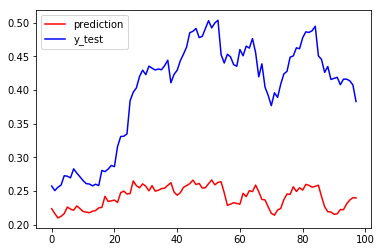

In [14]:
plt.plot(p,color='red', label='prediction')
#plt.plot(ratio, color='black', label='ratio')
#plt.plot(diff, color='purple', label='diff')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='best')
plt.show()